# LRG Templates

The goal of this notebook is to use observations of a large number of luminous red galaxies (LRGs) with DECaLS/DR7 *grzW1W2* photometry and ancillary spectroscopic redshifts to generate a set of spectroscopic templates suitable for spectroscopic simulations, targeting investigations, and other DESI-related projects.

The parent sample consists of 3,783,674 LRGs 

selected from the official DECaLS/DR7.1 target catalog `targets-dr7.1-0.23.0.fits` using the selection criterion
```python
DESI_TARGET & desi_mask.LRG != 0
```

Subsequently, Rongpu Zhou (Pittsburgh) assembled spectroscopic redshifts for the sample from SDSS/Main, BOSS, AGES, DEEP2, and VIPERS, supplemented with COSMOS medium-band photometric redshifts, yielding precise redshifts for 62,177 objects (2.4% of the parent sample).  Using these data, Zhou used a random forest technique (described elsewhere) to compute photometric redshifts for the complete sample, producing the catalog `dr3.1-0.14.0-lrg-rf-photoz-0.2.fits`, which we use as input into the generation of the spectral templates.

Specifically, we generate templates using the following procedure:
  1.  We focus exclusively on the subset of 62,177 LRGs with spectroscopic redshifts since we find that the training sample is fairly representative of the full sample in the four-dimensional space of *g-r*, *r-z*, *z*-band magnitude, and redshift.  (Future versions of these templates may utilize the random forest photometric redshifts.)
  2. We use the Bayesian spectral energy distribution (SED) modeling code [iSEDfit](http://www.sos.siena.edu/~jmoustakas/isedfit) and the CKC14z simple stellar population models of Conroy et al. to model the observed SEDs of the parent sample of galaxies.  The outputs of this code are the best-fitting (maximum likelihood) spectroscopic template and the marginalized posterior distributions on a large number of quantities of interest, stored in the file `legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits`.  In addition, we compute K-corrected absolute magnitudes in the DECaLS *g*-, *r*-, and *z*-band bandpasses and store them in the file `legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits`.  The code that generates these files is [desi_legacysurvey_lrg_isedfit](https://github.com/moustakas/moustakas-projects/blob/master/desi/templates/desi_legacysurvey_lrg_isedfit.pro).
  3. Next, the notebook below documents how we select a "representative" subset of these galaxies to serve as our LRG template set.
  4. Finally, we generate the templates themselves using the IDL script [build_lrg_basis_templates](https://desi.lbl.gov/svn/docs/technotes/spectro/lrg-templates/trunk/pro/build_lrg_basis_templates).  

In [1]:
import os
import numpy as np

from astropy.table import Table, hstack
from scipy.spatial import cKDTree as KDTree

In [2]:
import matplotlib.pyplot as plt
from corner import corner

In [3]:
plt.style.use('seaborn-talk')
%matplotlib inline

### Establish the random and pathnames.

In [4]:
seed = 123
rand = np.random.RandomState(seed)

In [5]:
isedfit_version = 'v1.0'
templates_version = 'v2.0'

In [6]:
isedfit_dir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'templates', 'lrg_templates', 'isedfit', isedfit_version)

In [7]:
metadata_outfile = os.path.join(isedfit_dir, 'lrg-templates-isedfit-{}.fits'.format(isedfit_version))

### Read the iSEDfit and absolute magnitude catalogs.

In [8]:
def read_isedfit():
    """Read the iSEDfit fitting results."""
    
    isedfile = os.path.join(isedfit_dir, 'legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits.gz')
    kcorrfile = os.path.join(isedfit_dir, 'legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits.gz')

    print('Reading {}'.format(isedfile))
    ised = Table.read(isedfile)
    print('Reading {}'.format(kcorrfile))
    kcorr = Table.read(kcorrfile)
    
    snrmin = 3.0
    chi2min = 10
    
    keep = np.where(
        (ised['CHI2'] < chi2min) * 
        (np.sum(ised['MAGGIES'] * np.sqrt(ised['IVARMAGGIES']) > snrmin, axis=1) == 5)
    )[0]
    print('Read {} galaxies with chi2 < {} and S/N > {} in all 5 photometric bands.'.format(
        len(keep), chi2min, snrmin))
    
    cat = dict()
    cat['redshift'] = kcorr['Z'][keep].data
    cat['Mstar'] = ised['MSTAR_50'][keep].data
    cat['Mg'] = kcorr['ABSMAG'][keep, 0].data
    cat['Mr'] = kcorr['ABSMAG'][keep, 1].data
    cat['Mz'] = kcorr['ABSMAG'][keep, 2].data
    cat['gr'] = cat['Mg'] - cat['Mr']
    cat['rz'] = cat['Mr'] - cat['Mz']

    with np.errstate(invalid='ignore'):
        cat['grobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 0].data / ised['MAGGIES'][keep, 1].data )
        cat['rzobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 1].data / ised['MAGGIES'][keep, 2].data )
        cat['zW1obs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 2].data / ised['MAGGIES'][keep, 3].data )
     
    #mm = - 2.5 * np.log10(ised['MAGGIES'][keep, 0].data)
    #_ = plt.hist(mm, bins=100)
    
    kcorr.remove_columns(['Z', 'ISEDFIT_ID', 'MAGGIES', 'IVARMAGGIES'])
    out = hstack([ised[keep], kcorr[keep]])
    
    return cat, out

In [9]:
cat, ised = read_isedfit()

Reading /Users/ioannis/work/desi/spectro/templates/lrg_templates/isedfit/v1.0/legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits.gz
Reading /Users/ioannis/work/desi/spectro/templates/lrg_templates/isedfit/v1.0/legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits.gz
Read 48760 galaxies with chi2 < 10 and S/N > 3.0 in all 5 photometric bands.


In [10]:
print(cat.keys())

dict_keys(['Mz', 'redshift', 'rzobs', 'Mg', 'Mr', 'zW1obs', 'gr', 'Mstar', 'rz', 'grobs'])


In [11]:
ised[:2]

ISEDFIT_ID,RA,DEC,Z,MAGGIES [5],IVARMAGGIES [5],BESTMAGGIES [5],CHUNKINDX,MODELINDX,DELAYED,BURSTTYPE,CHI2_1,TOTALMASS,TOTALMASS_ERR,MSTAR,AGE,SFRAGE,TAU,ZMETAL,AV,MU,OIIIHB,NLYC,SFR,SFR100,B100,B1000,EWOII,EWOIIIHB,EWNIIHA,NBURST,TRUNCTAU,TBURST,DTBURST,FBURST,MSTAR_50,AGE_50,SFRAGE_50,TAU_50,ZMETAL_50,AV_50,MU_50,OIIIHB_50,SFR_50,SFR100_50,B100_50,B1000_50,EWOII_50,EWOIIIHB_50,EWNIIHA_50,MSTAR_AVG,AGE_AVG,SFRAGE_AVG,TAU_AVG,ZMETAL_AVG,AV_AVG,MU_AVG,OIIIHB_AVG,SFR_AVG,SFR100_AVG,B100_AVG,B1000_AVG,EWOII_AVG,EWOIIIHB_AVG,EWNIIHA_AVG,MSTAR_ERR,AGE_ERR,SFRAGE_ERR,TAU_ERR,ZMETAL_ERR,AV_ERR,MU_ERR,OIIIHB_ERR,SFR_ERR,SFR100_ERR,B100_ERR,B1000_ERR,EWOII_ERR,EWOIIIHB_ERR,EWNIIHA_ERR,CHI2_2,FLAM_1500,CFLUX_3727,KCORRECT [3],ABSMAG [3],IVARABSMAG [3],SYNTH_ABSMAG [3],ABSMAG_FILTERLIST [3]
int32,float64,float64,float32,float32,float32,float32,int16,int16,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str11
0,7.10186257679,-3.84164260827,0.493305,1.7658e-09 .. 2.19342e-08,2.10202e+20 .. 1.63934e+17,1.95907e-09 .. 2.72933e-08,0,3005,1,1,3.4034,3.79652e+11,2.49584e+09,11.3572,8.43379,8.25055,0.0916157,0.00775165,0.208418,0.506265,-1.0,52.1077,-3.42061,-3.42061,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.3304,7.99743,6.93651,0.124043,0.00873057,0.314216,0.357754,-1.0,-3.42019,-3.42019,-15.0,-13.4455,-1.0,-1.0,-1.0,11.319,7.49219,6.91142,0.290627,0.0089476,0.36689,0.349315,-1.0,-2.85242,-3.17479,-10.7666,-10.4481,-1.0,-1.0,-1.0,0.059242,0.856211,0.86443,0.199598,0.00219014,0.323897,0.0918706,0.0,0.735066,0.493306,2.93409,3.00125,0.0,0.0,0.0,3.4034,8.62409e-19,1.93438e-17,0.0124708 .. 0.0714089,-22.1503 .. -23.2998,8778.52 .. 9104.59,-22.1392 .. -23.3014,decam_g.par .. decam_z.par
1,7.23270630501,-3.73900323383,0.596124,1.21947e-09 .. 3.73271e-08,3.41204e+20 .. 1.61952e+17,1.38542e-09 .. 4.38815e-08,0,1746,1,1,4.81293,7.38799e+11,3.82096e+09,11.6527,6.85219,6.73449,0.0588457,0.0144248,0.174484,0.521158,-1.0,52.1897,-3.13147,-3.13147,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.6497,6.91977,6.72835,0.100916,0.0144248,0.406731,0.254227,-1.0,-3.12706,-3.13482,-15.0,-15.0,-1.0,-1.0,-1.0,11.6523,7.06551,6.69376,0.185881,0.0141004,0.372666,0.320061,-1.0,-2.96507,-3.12227,-12.9086,-12.6098,-1.0,-1.0,-1.0,0.0230553,0.353224,0.365486,0.113796,0.00143068,0.188852,0.0777556,0.0,0.249084,0.024488,2.43004,2.54153,0.0,0.0,0.0,4.81293,6.44898e-19,1.93495e-17,0.415429 .. 0.191121,-22.7973 .. -24.0572,9283.86 .. 18576.3,-22.7938 .. -24.0487,decam_g.par .. decam_z.par


### Visualize the sample in the rest-frame and the observed frame.

In [12]:
zlim, Mrlim, grlim, rzlim = (0.2, 1.1), (-21, -25), (0.2, 1.2), (0.2, 0.8)

In [13]:
def qa_rest_corner():
    fig = corner(np.vstack((cat['redshift'], cat['Mr'], cat['gr'], cat['rz'])).T, 
                 labels=('Redshift', r'$M_{0.0r}$', r'$^{0.0}(g - r)$', r'$^{0.0}(r - z)$'),
                 range=(zlim, Mrlim, grlim, rzlim))

#### Corner plot showing the inter-relationship of various rest-frame quantities.

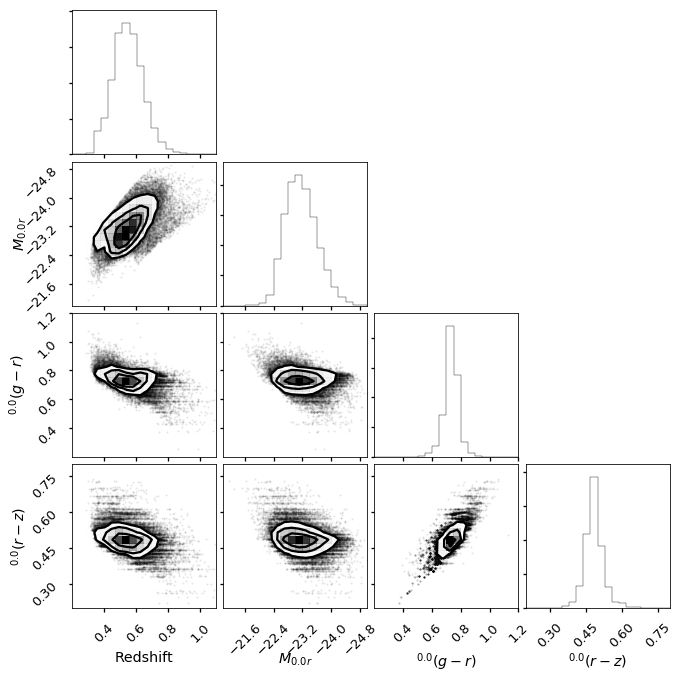

In [14]:
qa_rest_corner()

In [15]:
def qa_rest():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    ax1.hexbin(cat['redshift'], cat['Mr'], mincnt=1, bins='log', 
                    cmap=plt.cm.get_cmap('RdYlBu'))
    ax1.set_ylim(Mrlim)
    ax1.set_xlim(zlim)
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel(r'$M_{0.0r}$')
    
    ax2.hexbin(cat['redshift'], cat['gr'], mincnt=1, bins='log', 
               cmap=plt.cm.get_cmap('RdYlBu'))
    ax2.set_xlim(zlim)
    ax2.set_ylim(grlim)
    ax2.set_xlabel('Redshift')
    ax2.set_ylabel(r'$^{0.0}(g - r)$')
    
    ax3.hexbin(cat['rz'], cat['gr'], mincnt=1, bins='log', 
               cmap=plt.cm.get_cmap('RdYlBu'))
    ax3.set_xlabel(r'$^{0.0}(r - z)$')
    ax3.set_ylabel(r'$^{0.0}(g - r)$')
    ax3.set_ylim(grlim)
    ax3.set_xlim(rzlim)
    
    hb = ax4.hexbin(cat['Mr'], cat['gr'], mincnt=1, bins='log', 
                    cmap=plt.cm.get_cmap('RdYlBu'))
    ax4.set_xlabel(r'$M_{0.0r}$')
    ax4.set_ylabel(r'$^{0.0}(g - r)$')
    ax4.set_xlim(Mrlim)
    ax4.set_ylim(grlim)
   
    cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(hb, cax=cax, label=r'$\log_{10}$ (Number of Galaxies)')

    for aa in (ax1, ax2, ax3, ax4):
        aa.grid(True)
    
    plt.subplots_adjust(wspace=0.2, right=0.85)

#### Another version of the previous plot but focusing on particular relationships.

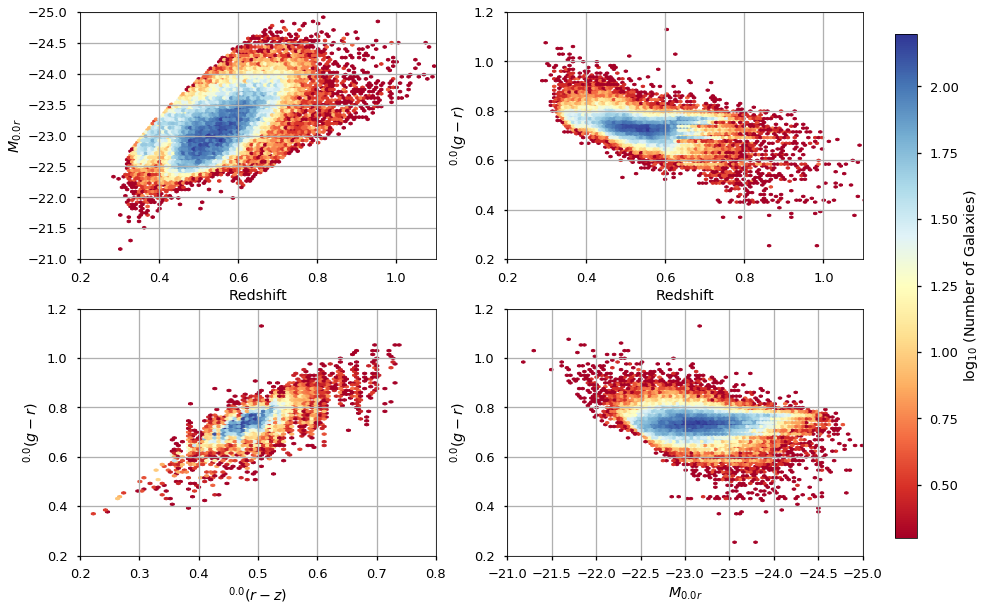

In [16]:
qa_rest()

#### Now let's look at observed color-color space.

In [17]:
grobslim, rzobslim = (0.5, 3), (0.8, 2.2)

In [18]:
def qa_obs():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.hexbin(cat['rzobs'], cat['grobs'], mincnt=1, bins='log', 
               cmap=plt.cm.get_cmap('RdYlBu'))
    ax1.set_xlabel(r'$(r - z)_{\rm obs}$')
    ax1.set_ylabel(r'$(g - r)_{\rm obs}$')
    
    hb = ax2.hexbin(cat['rzobs'], cat['zW1obs'], mincnt=1, bins='log', 
                    cmap=plt.cm.get_cmap('RdYlBu'))
    cb = plt.colorbar(hb)
    cb.set_label(r'$\log_{10}$ (Number of Galaxies)')

    ax2.set_ylabel(r'$(r - z)_{\rm obs}$')
    ax2.set_xlabel(r'$(z - W1)_{\rm obs}$')
    
    for aa in (ax1, ax2):
        aa.grid(True)

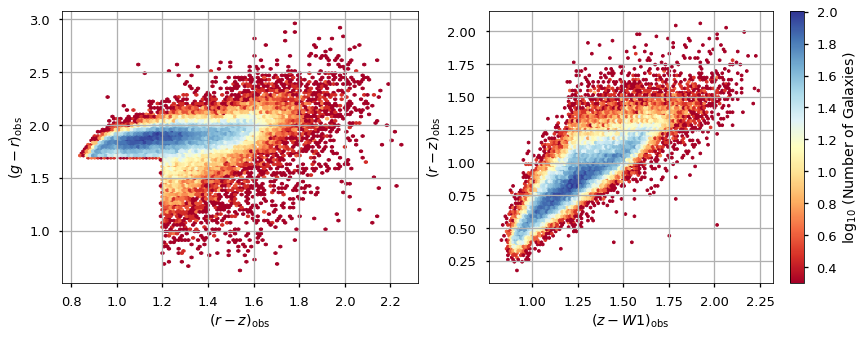

In [19]:
qa_obs()

### Group similar templates.

Here's the black magic.  The question is: what minimum set templates can be used to *describe* this population of LRGs. This problem is NP hard, although there are methods for solving it (see, e.g., the [SetCoverPy](https://github.com/guangtunbenzhu/SetCoverPy) algorithm).  Here we opt for a much simpler procedure.  

Based on the preceding plots, we have opted to use the *rest-frame* g-r and r-z color together with the r-band absolute magnitude to identify "like" galaxies.  Specifically, we simply choose a random subset of NPERBIN galaxies in each 3D bin (containing at least MINCOUNT objects) of rest-frame color-color-magnitude space.  This procedure has the benefit of being relatively simple and yielding diversity of templates.  

In addition, the NPERBIN and MINCOUNT parameters (as well as the size of the bins) can be tuned to yield the desired number of total templates.  Here, we opt for approximately ~1100 templates.

In [20]:
def group_templates(X_in, lim_in, delta_in):
    """Use scipy's binned_statistic_dd method to assigned galaxies to 
    fixed input bins.    
    """
    from scipy.stats import binned_statistic_dd
    
    nbins = [np.ceil(np.ptp(lim) / delta).astype('int') for lim, delta in zip(lim_in, delta_in)]

    X = np.vstack( X_in ).T

    stat, edges, num = binned_statistic_dd(X, _, statistic='count', bins=nbins, range=lim_in)
    
    index = [np.where(num == ii)[0] for ii in np.unique(num)]
    count = np.array([len(aa) for aa in index])
    
    return index, count

#### The unused code in the next cell demonstrates how, e.g., redshift can be used in the template selection.

In [21]:
if False:
    X_in = (cat['redshift'], cat['gr'], cat['rz'])
    lim_in = (zlim, grlim, rzlim)
    delta_in = (0.05, 0.05, 0.05)
else:
    X_in = (cat['Mr'], cat['gr'], cat['rz'])
    lim_in = (np.flip(Mrlim, 0), grlim, rzlim)
    delta_in = (0.1, 0.05, 0.05)    

In [22]:
%time index, count = group_templates(X_in, lim_in, delta_in)

CPU times: user 201 ms, sys: 10.2 ms, total: 212 ms
Wall time: 232 ms


In [23]:
print('Identified {} color-color bins with at least one galaxy:'.format(len(index)))
for mnmx in ((1, 5), (5, 10), (10, 30), (30, 100), (100, count.max()+1)):
    cnt = np.sum( (count >= mnmx[0]) * (count < mnmx[1]) ).astype('int')
    print('  {:03} bins with {} - {}'.format(cnt, mnmx[0], mnmx[1]))

Identified 924 color-color bins with at least one galaxy:
  457 bins with 1 - 5
  111 bins with 5 - 10
  141 bins with 10 - 30
  110 bins with 30 - 100
  105 bins with 100 - 1194


In [24]:
def choose_templates(mincount=3, nperbin=2):
    """Return the indices of the chosen templates and the responsibility, 
    or the number of galaxies in that template's bin.
    
    """
    if nperbin > mincount:
        print('NPERBIN should be less than or equal to MINCOUNT.')
        
    iarch = list()
    norm = list()
    good = np.where(count >= mincount)[0]
    for gg in good:
        iarch.append(rand.choice(index[gg], nperbin, replace=False))
        
    iarch = np.hstack(iarch)
    resp = count[good]
    
    print('Chose {} templates to represent {} galaxies.'.format(len(iarch), np.sum(resp)))
    
    return iarch, resp

In [25]:
iarch, resp = choose_templates()

Chose 1142 templates to represent 48294 galaxies.


In [26]:
def _markers():
    size = 50 * (1+(resp - resp.min()) / resp.ptp())
    shade = (cat['gr'][iarch] - cat['gr'][iarch].min()) / cat['gr'][iarch].ptp()
    col = plt.cm.coolwarm(shade)
    return size, col

In [27]:
def qa_templates():
    """Generate a color-color plot with the symbol size scaled by the responsibility.
    
    """
    
    size, col = _markers()

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.scatter(cat['rzobs'], cat['grobs'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax1.scatter(cat['rzobs'][iarch], cat['grobs'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax1.set_xlabel(r'$(r - z)_{\rm obs}$')
    ax1.set_ylabel(r'$(g - r)_{\rm obs}$')

    ax2.scatter(cat['zW1obs'], cat['rzobs'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax2.scatter(cat['zW1obs'][iarch], cat['rzobs'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax2.set_ylabel(r'$(r - z)_{\rm obs}$')
    ax2.set_xlabel(r'$(z - W1)_{\rm obs}$')

    ax3.scatter(cat['rz'], cat['gr'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax3.scatter(cat['rz'][iarch], cat['gr'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax3.set_xlabel(r'$^{0.0}(r - z)$')
    ax3.set_ylabel(r'$^{0.0}(g - r)$')
    ax3.set_ylim(grlim)
    ax3.set_xlim(rzlim)
    
    ax4.scatter(cat['Mr'], cat['gr'], s=10, c='lightgray', alpha=0.5, edgecolor='k')
    ax4.scatter(cat['Mr'][iarch], cat['gr'][iarch], c=col, marker='o', s=size, 
                alpha=0.9, edgecolor='k')
    ax4.set_xlabel(r'$M_{0.0r}$')
    ax4.set_ylabel(r'$^{0.0}(g - r)$')
    ax4.set_xlim(Mrlim)
    ax4.set_ylim(grlim)
    
    for aa in (ax1, ax2, ax3, ax4):
        aa.grid(True)    
    
    fig.subplots_adjust(wspace=0.3)

#### Symbol size is proportional to "responsibility" (*nperbin*) and color is proportional to rest-frame g-r color.

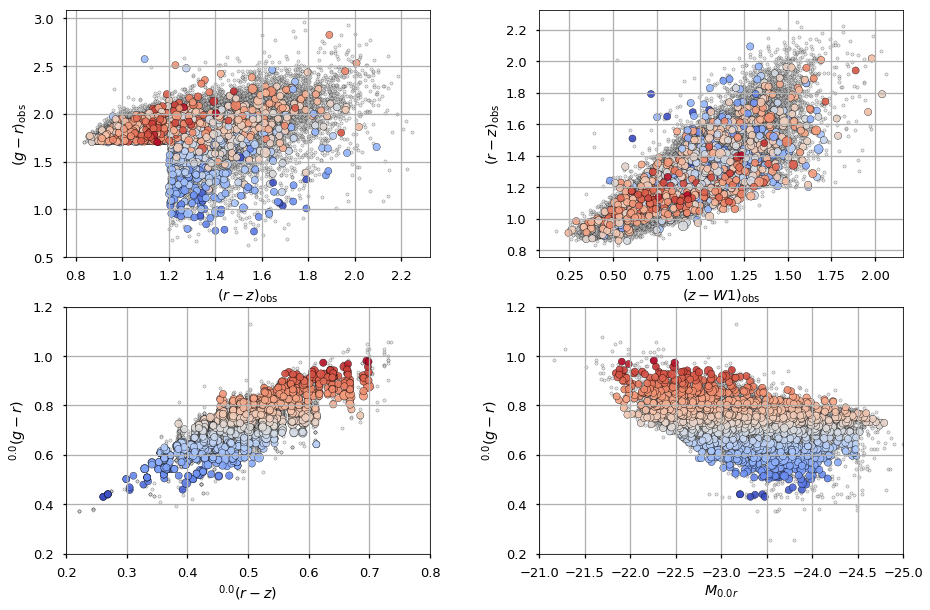

In [28]:
qa_templates()

#### Some additional diagnostics of the templates.

*SFR100* is the star formation rate (SFR) averaged over the previous 100 Myr.  Note that templates with higher SFRs are somewhat over-represented in the template set because we choose templates with equal probability, not weighted by the number of galaxies in each cell.

In [29]:
def qa_template_properties():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    ax1.hist(ised['MSTAR_50'], normed=True, bins=30, label='Full Sample')
    ax1.hist(ised['MSTAR_50'][iarch], normed=True, bins=30, alpha=0.5,
            label='Templates')
    ax1.set_xlabel(r'$\log_{10}\ (M\ /\ M_{\odot})$')
    ax1.set_ylabel('Relative Number')
    
    ax2.hist(ised['SFR100_50'], normed=True, bins=30, label='Full Sample')
    ax2.hist(ised['SFR100_50'][iarch], normed=True, bins=30, alpha=0.5,
            label='Templates')    
    ax2.set_xlabel(r'$\log_{10}\ (SFR_{100}\ /\ M_{\odot}\ {\rm yr}^{-1})$')
    ax2.legend(loc='upper right')
    
    plt.subplots_adjust(wspace=0.02)

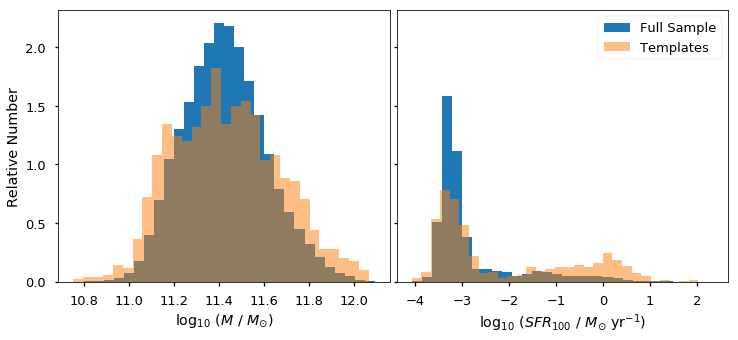

In [30]:
qa_template_properties()

### Write out the metadata.

In [31]:
print('Writing {}'.format(metadata_outfile))
ised[iarch].write(metadata_outfile, overwrite=True)

Writing /Users/ioannis/work/desi/spectro/templates/lrg_templates/isedfit/v1.0/lrg-templates-isedfit-v1.0.fits


### Visualize the resulting templates.

The spectra have to built in IDL using the script [build_lrg_basis_templates](https://desi.lbl.gov/svn/docs/technotes/spectro/lrg-templates/trunk/pro/build_lrg_basis_templates), which we assume has happend.

In [32]:
from desisim.io import read_basis_templates

In [33]:
flux, wave, meta = read_basis_templates('LRG')
nt = len(meta)
print('Number of templates = {}'.format(nt))

INFO:io.py:967:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.4/lrg_templates_v2.0.fits
Number of templates = 1142


In [34]:
meta

TEMPLATEID,ISEDFIT_ID,RA,DEC,Z,MAGGIES [5],IVARMAGGIES [5],LOGMSTAR,LOGSFR,LOGSFR100,AV_ISM,AGE,SFRAGE,HBETA_CONTINUUM,D4000
int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,38770,161.660797922,1.97397367619,0.71782,2.08524e-09 .. 8.69486e-08,1.98737e+20 .. 1.28632e+17,12.0261,-1.66163,-2.24998,0.128075,6.01099,5.14897,1.99862e-11,1.66315
1,23729,39.2093188094,1.59300022774,0.717651,2.0286e-09 .. 8.40202e-08,2.14052e+20 .. 2.16765e+17,11.9925,-2.72429,-2.76725,0.00245502,5.81657,5.73288,2.07025e-11,1.68762
2,51254,320.064308494,1.05913990242,0.718637,1.92813e-09 .. 9.23302e-08,7.5455e+19 .. 1.16828e+17,11.9723,-0.873839,-1.54265,0.054885,6.2494,4.95156,2.04717e-11,1.70254
3,40678,189.854531375,16.8652325633,0.688099,3.12021e-09 .. 9.45608e-08,1.001e+19 .. 2.975e+16,12.0011,-0.562495,-1.24566,0.249544,7.13826,5.44655,1.8156e-11,1.60199
4,20609,39.5509326937,-1.04702936438,0.750491,1.19407e-09 .. 7.81926e-08,1.78903e+20 .. 1.65252e+17,11.9544,-1.67601,-2.35385,0.0609844,5.86437,5.02941,2.06431e-11,1.6996
5,3290,8.53597744677,2.36587590113,0.711337,1.74082e-09 .. 7.51581e-08,3.75509e+20 .. 9.77913e+16,12.0359,-2.44352,-2.67418,0.13193,6.99169,6.95464,1.63681e-11,1.70158
6,45556,233.467890919,2.63126371621,0.65419,3.23746e-09 .. 8.56976e-08,1.6822e+20 .. 1.1953e+17,11.8795,-0.11013,-0.87015,0.228251,6.53615,4.90406,2.10307e-11,1.53727
7,5660,6.83683725088,9.88747892345,0.659286,2.74467e-09 .. 1.16089e-07,3.76665e+19 .. 1.01018e+17,11.8445,-0.551618,-1.33846,0.0280358,2.73457,2.26376,3.34019e-11,1.68822
8,18215,34.0672896261,-0.57431686995,0.669621,1.9005e-09 .. 6.34756e-08,6.16894e+19 .. 5.56466e+16,11.9387,-2.45091,-2.68314,0.13193,6.99169,6.95464,1.63682e-11,1.70158


In [35]:
def plot_subset(nplot=25, ncol=5):
    """Plot a random sampling of the basis templates."""
    nspec, npix = flux.shape
    nrow = np.ceil(nplot / ncol).astype('int')
    these = rand.choice(nspec, nplot, replace=False)
    fig, ax = plt.subplots(nrow, ncol, figsize=(2.2*ncol, 2.2*nrow), sharey=True, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :])
        thisax.text(0.95, 0.93, '{:0d}'.format(indx), ha='right', 
             va='top', transform=thisax.transAxes, fontsize=11)
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        thisax.set_xscale('log')
        thisax.set_yscale('log')
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

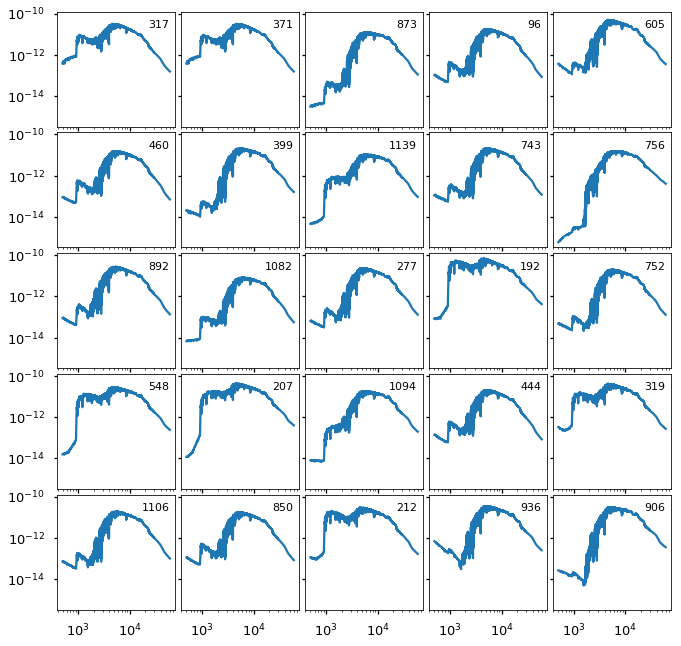

In [36]:
plot_subset()

### Finally, compare the colors of the templates to the data.

This test brings this analysis full circle.

In [37]:
def zgrid_colors():
    """Compute the colors of the templates on a fixed redshift grid."""
    from speclite import filters
    filt = filters.load_filters('decam2014-g', 'decam2014-r', 'decam2014-z', 'wise2010-W1')
    
    zmin, zmax, dz = 0.0, 1.0, 0.1
    nz = np.round( (zmax - zmin) / dz ).astype('i2')
    print('Number of redshift points = {}'.format(nz))

    cc = dict(
        redshift = np.linspace(0.0, 2.0, nz),
        gr = np.zeros( (nt, nz) ),
        rz = np.zeros( (nt, nz) ),
        zW1 = np.zeros( (nt, nz), )
    )    
    
    for iz, red in enumerate(cc['redshift']):
        zwave = wave.astype('float') * (1 + red)
        phot = filt.get_ab_maggies(flux, zwave, mask_invalid=False)
        cc['gr'][:, iz] = -2.5 * np.log10( phot['decam2014-g'] / phot['decam2014-r'] )
        cc['rz'][:, iz] = -2.5 * np.log10( phot['decam2014-r'] / phot['decam2014-z'] )
        cc['zW1'][:, iz] = -2.5 * np.log10( phot['decam2014-z'] / phot['wise2010-W1'] )
    
    return cc    

In [38]:
%time cc = zgrid_colors()

Number of redshift points = 10
CPU times: user 3.93 s, sys: 2.45 s, total: 6.38 s
Wall time: 8.07 s


In [39]:
grrange = (0.0, 3.0)
rzrange = (0.0, 2.5)
zW1range = (-1, 4)
ntspace = 20 # spacing between model curves

In [40]:
def grz(pngfile=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    hb = ax1.hexbin(cat['rzobs'], cat['grobs'], bins='log', 
                   mincnt=1, extent=rzrange+grrange,
                   cmap=plt.cm.get_cmap('RdYlBu'))
    ax1.set_xlabel(r'$(r - z)_{\rm obs}$')
    ax1.set_ylabel(r'$(g - r)_{\rm obs}$')
    ax1.set_xlim(rzrange)
    ax1.set_ylim(grrange)
    ax1.text(0.05, 0.9, 'Data', ha='left', va='bottom',
             transform=ax1.transAxes, fontsize=14)

    cb = fig.colorbar(hb, ax=ax1)
    cb.set_label(r'log$_{10}$ (Number of Galaxies)')
    
    for tt in np.arange(0, nt, ntspace):
        ax2.plot(cc['rz'][tt, :], cc['gr'][tt, :], marker='s', 
                markersize=5, ls='-', alpha=0.5)
        
    for tt in np.arange(0, nt, ntspace):
        ax2.scatter(cc['rz'][tt, 0], cc['gr'][tt, 0], marker='o', 
                   facecolors='none', s=80, edgecolors='k',
                   linewidth=2)
        
    ax2.text(0.1, 0.05, 'z=0', ha='left', va='bottom',
             transform=ax2.transAxes, fontsize=14)
    ax2.text(0.05, 0.9, 'Models (z=0-1, dz=0.1)', ha='left', va='bottom',
             transform=ax2.transAxes, fontsize=14)
    
    ax2.set_xlim(rzrange)
    ax2.set_ylim(grrange)
    ax2.set_xlabel(r'$(r - z)_{\rm obs}$')
    ax2.set_ylabel(r'$(g - r)_{\rm obs}$')
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    
    plt.subplots_adjust(wspace=0.15)
    
    if pngfile:
        fig.savefig(pngfile)

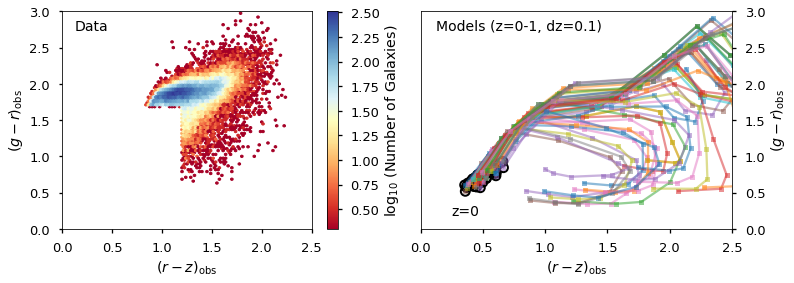

In [41]:
grz()

In [42]:
def rzW1(pngfile=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    hb = ax1.hexbin(cat['zW1obs'], cat['rzobs'], bins='log', 
                   mincnt=1, extent=rzrange+grrange,
                   cmap=plt.cm.get_cmap('RdYlBu'))

    ax1.set_ylabel(r'$(r - z)_{\rm obs}$')
    ax1.set_xlabel(r'$(z - W1)_{\rm obs}$')
    ax1.set_xlim(zW1range)
    ax1.set_ylim(rzrange)
    ax1.text(0.05, 0.9, 'Data', ha='left', va='bottom',
             transform=ax1.transAxes, fontsize=14)

    cb = fig.colorbar(hb, ax=ax1)
    cb.set_label(r'log$_{10}$ (Number of Galaxies)')
    
    for tt in np.arange(0, nt, ntspace):
        ax2.plot(cc['zW1'][tt, :], cc['rz'][tt, :], marker='s', 
                markersize=5, ls='-', alpha=0.5)
        
    for tt in np.arange(0, nt, ntspace):
        ax2.scatter(cc['zW1'][tt, 0], cc['rz'][tt, 0], marker='o', 
                   facecolors='none', s=80, edgecolors='k',
                   linewidth=2)
        
    ax2.text(0.01, 0.05, 'z=0', ha='left', va='bottom',
             transform=ax2.transAxes, fontsize=14)
    ax2.text(0.05, 0.9, 'Models (z=0-1, dz=0.1)', ha='left', va='bottom',
             transform=ax2.transAxes, fontsize=14)
    
    ax2.set_xlim(zW1range)
    ax2.set_ylim(rzrange)
    ax2.set_xlabel(r'$(z - W1)_{\rm obs}$')
    ax2.set_ylabel(r'$(r - z)_{\rm obs}$')
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    
    plt.subplots_adjust(wspace=0.15)
    
    if pngfile:
        fig.savefig(pngfile)

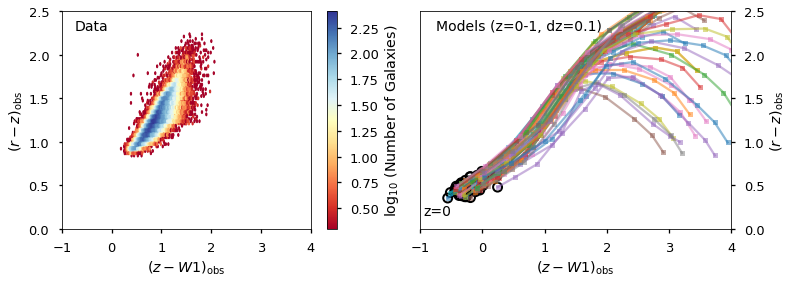

In [43]:
rzW1()